In [40]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
import torch.nn.functional as F
import numpy as np

# Load the RoBERTa model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

# def calculate_perplexity(sentence, model, tokenizer):
#     encoded_input = tokenizer(sentence, return_tensors='pt', truncation=True)
#     input_ids = encoded_input['input_ids'].squeeze()  # Shape: [seq_len]
#     attention_mask = encoded_input['attention_mask']
    
#     total_log_prob = 0.0
#     N = len(input_ids)
    
#     for i in range(1, N-1):  # Skip [CLS] and [SEP] if present
#         masked_input_ids = input_ids.clone()  # Clone to avoid in-place modification
#         masked_input_ids[i] = tokenizer.mask_token_id  # Mask the i-th token
        
#         # Predict the masked token
#         with torch.no_grad():
#             outputs = model(input_ids=masked_input_ids.unsqueeze(0), attention_mask=attention_mask)
#             logits = outputs.logits
        
#         # Convert logits to probabilities
#         predicted_probs = F.softmax(logits[0, i], dim=-1)
        
#         # Get the probability of the original token
#         original_token_id = input_ids[i].item()
#         original_token_prob = predicted_probs[original_token_id].item()
        
#         # Add the log probability of the original token
#         total_log_prob += np.log(original_token_prob)
    
#     # Compute pseudo-perplexity
#     avg_log_prob = total_log_prob / (N - 2)  # Exclude [CLS] and [SEP] tokens
#     pseudo_perplexity = np.exp(-avg_log_prob)
    
#     return pseudo_perplexity

def score(sentence, model, tokenizer):
    # https://arxiv.org/abs/1910.14659
    tensor_input = tokenizer(sentence, return_tensors='pt', truncation=True)
    repeat_input = tensor_input['input_ids'].repeat(tensor_input['input_ids'].size(-1)-2, 1)
    mask = torch.ones(tensor_input['input_ids'].size(-1) - 1).diag(1)[:-2]
    masked_input = repeat_input.masked_fill(mask == 1, tokenizer.mask_token_id)
    labels = repeat_input.masked_fill( masked_input != tokenizer.mask_token_id, -100)
    with torch.inference_mode():
        loss = model(masked_input, labels=labels).loss
    return np.exp(loss.item())


# Example usage
sentence = "London is the capital of Great Britain."
pseudo_perplexity = score(sentence, model, tokenizer)
print("Pseudo-perplexity:", pseudo_perplexity)



Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Pseudo-perplexity: 1.0968683577162155


In [41]:
from datasets import load_dataset

ds_book_corpus = load_dataset("bookcorpus/bookcorpus", trust_remote_code=True)

In [121]:
# select entry at random
random_entry = ds_book_corpus['train'][np.random.randint(len(ds_book_corpus['train']))]['text']
# use the tokenizer and grab the first 5 tokens from the entry
tokens = tokenizer.tokenize(random_entry)[:5]

In [122]:
tokens

['what', '?']

In [125]:

CLS = '[CLS]'
SEP = '[SEP]'
MASK = '[MASK]'
mask_id = tokenizer.convert_tokens_to_ids([MASK])[0]
sep_id = tokenizer.convert_tokens_to_ids([SEP])[0]
cls_id = tokenizer.convert_tokens_to_ids([CLS])[0]


In [127]:

def tokenize_batch(batch):
    return [tokenizer.convert_tokens_to_ids(sent) for sent in batch]

def untokenize_batch(batch):
    return [tokenizer.convert_ids_to_tokens(sent) for sent in batch]

def detokenize(sent):
    """ Roughly detokenizes (mainly undoes wordpiece) """
    new_sent = []
    for i, tok in enumerate(sent):
        if tok.startswith("##"):
            new_sent[len(new_sent) - 1] = new_sent[len(new_sent) - 1] + tok[2:]
        else:
            new_sent.append(tok)
    return new_sent



def generate_step(out, gen_idx, temperature=None, top_k=0, sample=False, return_list=True):
    """ Generate a word from from out[gen_idx]
    
    args:
        - out (torch.Tensor): tensor of logits of size batch_size x seq_len x vocab_size
        - gen_idx (int): location for which to generate for
        - top_k (int): if >0, only sample from the top k most probable words
        - sample (Bool): if True, sample from full distribution. Overridden by top_k 
    """
    logits = out[:, gen_idx]
    if temperature is not None:
        logits = logits / temperature
    if top_k > 0:
        kth_vals, kth_idx = logits.topk(top_k, dim=-1)
        dist = torch.distributions.categorical.Categorical(logits=kth_vals)
        idx = kth_idx.gather(dim=1, index=dist.sample().unsqueeze(-1)).squeeze(-1)
    elif sample:
        dist = torch.distributions.categorical.Categorical(logits=logits)
        idx = dist.sample().squeeze(-1)
    else:
        idx = torch.argmax(logits, dim=-1)
    return idx.tolist() if return_list else idx
     

In [130]:
# Generation modes as functions
import math
import time

def get_init_text(seed_text, max_len, batch_size = 1, rand_init=False):
    """ Get initial sentence by padding seed_text with either masks or random words to max_len """
    batch = [seed_text + [MASK] * max_len + [SEP] for _ in range(batch_size)]
    #if rand_init:
    #    for ii in range(max_len):
    #        init_idx[seed_len+ii] = np.random.randint(0, len(tokenizer.vocab))
    
    return tokenize_batch(batch)

def parallel_sequential_generation(seed_text, max_len=15, top_k=0, temperature=None, max_iter=300, burnin=200,
                                   cuda=False, print_every=10, verbose=True, batch_size=2):
    """ Generate for one random position at a timestep
    
    args:
        - burnin: during burn-in period, sample from full distribution; afterwards take argmax
    """
    seed_len = len(seed_text)
    batch = get_init_text(seed_text, max_len, batch_size)
    
    for ii in range(max_iter):
        kk = np.random.randint(0, max_len)
        for jj in range(batch_size):
            batch[jj][seed_len+kk] = mask_id
        inp = torch.tensor(batch).cuda() if cuda else torch.tensor(batch)
        out = model(inp)
        topk = top_k if (ii >= burnin) else 0
        idxs = generate_step(out, gen_idx=seed_len+kk, top_k=topk, temperature=temperature, sample=(ii < burnin))
        for jj in range(batch_size):
            batch[jj][seed_len+kk] = idxs[jj]
            
        if verbose and np.mod(ii+1, print_every) == 0:
            for_print = tokenizer.convert_ids_to_tokens(batch[0])
            for_print = for_print[:seed_len+kk+1] + ['(*)'] + for_print[seed_len+kk+1:]
            print("iter", ii+1, " ".join(for_print))
            
    return untokenize_batch(batch)

def parallel_generation(seed_text, max_len=15, top_k=0, temperature=None, max_iter=300, sample=True, 
                        cuda=False, print_every=10, verbose=True, batch_size=2):
    """ Generate for all positions at a time step """
    seed_len = len(seed_text)
    batch = get_init_text(seed_text, max_len, batch_size)
    
    for ii in range(max_iter):
        inp = torch.tensor(batch).cuda() if cuda else torch.tensor(batch)
        out = model(inp)
        for kk in range(max_len):
            idxs = generate_step(out, gen_idx=seed_len+kk, top_k=top_k, temperature=temperature, sample=sample)
            for jj in range(batch_size):
                batch[jj][seed_len+kk] = idxs[jj]
            
        if verbose and np.mod(ii, print_every) == 0:
            print("iter", ii+1, " ".join(tokenizer.convert_ids_to_tokens(batch[0])))
    
    return untokenize_batch(batch)
            
def sequential_generation(seed_text, batch_size=2, max_len=15, leed_out_len=15, 
                          top_k=0, temperature=None, sample=True, cuda=False):
    """ Generate one word at a time, in L->R order """
    seed_len = len(seed_text)
    batch = get_init_text(seed_text, max_len, batch_size)
    batch = batch.cuda() if cuda else batch
    
    for ii in range(max_len):
        inp = [sent[:seed_len+ii+leed_out_len]+[sep_id] for sent in batch]
        inp = torch.tensor(batch).cuda() if cuda else torch.tensor(batch)
        out = model(inp)
        idxs = generate_step(out, gen_idx=seed_len+ii, top_k=top_k, temperature=temperature, sample=sample)
        for jj in range(batch_size):
            batch[jj][seed_len+ii] = idxs[jj]
        
        return untokenize_batch(batch)


def generate(n_samples, seed_text="[CLS]", batch_size=10, max_len=25, 
             sample=True, top_k=100, temperature=1.0, burnin=200, max_iter=500,
             cuda=False, print_every=1):
    # main generation function to call
    sentences = []
    n_batches = math.ceil(n_samples / batch_size)
    start_time = time.time()
    for batch_n in range(n_batches):
        batch = parallel_sequential_generation(seed_text, max_len=max_len, top_k=top_k,
                                               temperature=temperature, burnin=burnin, max_iter=max_iter, 
                                               cuda=cuda, verbose=False)
        
        #batch = sequential_generation(seed_text, batch_size=20, max_len=max_len, top_k=top_k, temperature=temperature, leed_out_len=leed_out_len, sample=sample)
        #batch = parallel_generation(seed_text, max_len=max_len, top_k=top_k, temperature=temperature, sample=sample, max_iter=max_iter)
        
        if (batch_n + 1) % print_every == 0:
            print("Finished batch %d in %.3fs" % (batch_n + 1, time.time() - start_time))
            start_time = time.time()
        
        sentences += batch
    return sentences
     

# Utility functions

def printer(sent, should_detokenize=True):
    if should_detokenize:
        sent = detokenize(sent)[1:-1]
    print(" ".join(sent))
    
def read_sents(in_file, should_detokenize=False):
    sents = [sent.strip().split() for sent in open(in_file).readlines()]
    if should_detokenize:
        sents = [detokenize(sent) for sent in sents]
    return sents

def write_sents(out_file, sents, should_detokenize=False):
    with open(out_file, "w") as out_fh:
        for sent in sents:
            sent = detokenize(sent[1:-1]) if should_detokenize else sent
            out_fh.write("%s\n" % " ".join(sent))
     

In [132]:
n_samples = 1000
batch_size = 50
max_len = 40
top_k = 100
temperature = 0.7

model_version = 'bert-base-uncased'
leed_out_len = 5 # max_len
burnin = 250
sample = True
max_iter = 500

# Choose the prefix context
seed_text = "[CLS]".split()

for temp in [1.0]:
    bert_sents = generate(n_samples, seed_text=seed_text, batch_size=batch_size, max_len=max_len,
                          sample=sample, top_k=top_k, temperature=temp, burnin=burnin, max_iter=max_iter,
                          cuda=True)
    out_file = "data/%s-len%d-burnin%d-topk%d-temp%.3f.txt" % (model_version, max_len, burnin, top_k, temp)
    write_sents(out_file, bert_sents, should_detokenize=True)

AssertionError: Torch not compiled with CUDA enabled

In [131]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch.nn.functional as F
import numpy as np

# Load pre-trained model tokenizer (vocabulary)
modelpath = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(modelpath)

text = "dummy. although he had already eaten a large meal, he was still very hungry."
target = "hungry"
tokenized_text = tokenizer.tokenize(text)

# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = tokenized_text.index(target)
tokenized_text[masked_index] = '[MASK]'

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [1] * len(tokenized_text)
# this is for the dummy first sentence. 
segments_ids[0] = 0
segments_ids[1] = 0

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = AutoModelForMaskedLM.from_pretrained(modelpath)
model.eval()

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs.logits

# Get the predicted token
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])

print("Original:", text)
print("Masked:", " ".join(tokenized_text))
print("Predicted token:", predicted_token)

print("Other options:")
# Just curious about what the next few options look like.
for i in range(10):
    predictions[0, masked_index, predicted_index] = -float('inf')
    predicted_index = torch.argmax(predictions[0, masked_index]).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])
    print(predicted_token)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Original: dummy. although he had already eaten a large meal, he was still very hungry.
Masked: dummy . although he had already eaten a large meal , he was still very [MASK] .
Predicted token: ['hungry']
Other options:
['strong']
['tired']
['weak']
['angry']
['concerned']
['alert']
['nervous']
['pale']
['.']
['excited']


In [60]:
perplexities = []
zlib_entripies = []
import zlib
from tqdm import tqdm
for example_idx, passage in tqdm(enumerate(ds_book_corpus['train']), total=len(ds_book_corpus['train'])):
    passage = passage['text']
    perpl = score(passage, model, tokenizer)
    perplexities.append(perpl)
    # Zlib "entropy" of sample
    zlib_entropy = len(zlib.compress(bytes(passage, 'utf-8')))
    zlib_entripies.append(zlib_entropy)
    
    if example_idx>100:
        break




  0%|          | 101/74004228 [00:13<2699:08:12,  7.62it/s]


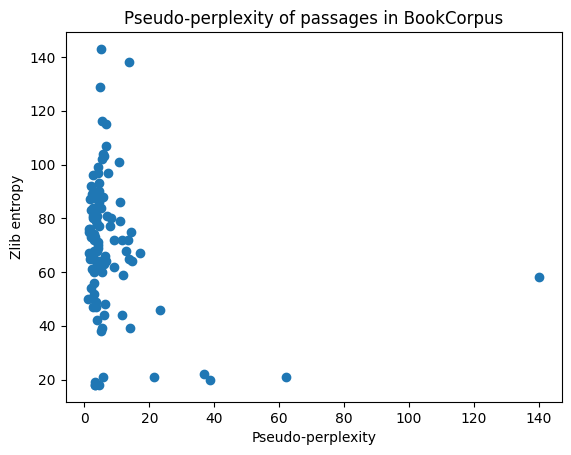

In [64]:
import matplotlib.pyplot as plt
plt.scatter(perplexities, zlib_entripies)
plt.xlabel("Pseudo-perplexity")
plt.ylabel("Zlib entropy")
plt.title("Pseudo-perplexity of passages in BookCorpus")
plt.show()
